### Import Dependencies

In [75]:
from pathlib import Path
import json
import math
from multiprocessing import Pool, cpu_count

from mplsoccer import Pitch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from tqdm import tqdm
import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    brier_score_loss,
    log_loss,
)
from xgboost import XGBClassifier

### Data Preprocessing

An xG model is fundamentally concerned with **shot context** and **shot outcomes**. For this model, we retain exactly two event types from the *Statsbomb Open Data - Events*:

`Shot`
- The target event of the xG model.
- Each shot provides the **label** (goal or non-goal) and the **spatial–contextual features** used to estimate scoring probability.

`Pass`
- Assists are represented as passes in the StatsBomb schema,
- Shot events are data-linked to the preceding assist via event IDs.

In [ ]:
DATA_DIR = Path(
    "statsbomb_open_data/data/events"
)

EVENT_TYPES_OF_INTEREST = {"Shot", "Pass"}


def load_event_file(path: Path):
    """
    Load a single StatsBomb event JSON file and
    retain only events relevant to the current analysis.
    """
    with path.open(encoding="utf-8") as f:
        events = json.load(f)

    return [
        event                                                # item
        for event in events                                  # iterable
        if event["type"]["name"] in EVENT_TYPES_OF_INTEREST  # condition
    ]

In [7]:
event_files = list(DATA_DIR.glob("*.json"))

with Pool(cpu_count()) as pool:
    per_file_events = list(
        tqdm(
            pool.imap_unordered(load_event_file, event_files),
            total=len(event_files),
            desc="Loading event files",
            unit="file",
        )
    )

Loading event files: 100%|██████████| 3464/3464 [00:58<00:00, 58.80file/s] 


In [9]:
# Flatten file-level lists into a single event stream
events = [event for file_events in per_file_events for event in file_events]

# Index events by ID for fast lookup in downstream joins
event_by_id = {
    event["id"]: event
    for event in events
    if "id" in event
}

### Helper functions

StatsBomb uses a **normalized rectangular pitch** with fixed dimensions:

- Pitch length: 120 units  
- Pitch width: 80 units  
- Coordinate origin: bottom-left corner  
- Attacking direction: left → right  

Under this convention:

- The opponent’s goal line lies at x = 120
- The vertical center of the pitch is y = 40
- The goal width is standardized at 8 units, spanning:
  - top post: y = 44
  - bottom post: y = 36

All spatial features in this xG model — such as shot distance and shot angle — are computed relative to this coordinate system.

In [32]:
GOAL_X = 120.0
GOAL_CENTER_Y = 40.0
GOAL_TOP_POST_Y = 44.0
GOAL_BOTTOM_POST_Y = 36.0 

In [34]:
def shot_distance(x: float, y: float) -> float:
    """
    Euclidean distance from shot location to the center of the goal.
    """
    return np.hypot(GOAL_X - x, GOAL_CENTER_Y - y)


def shot_angle(x: float, y: float) -> float:
    """
    Opening angle of the goal as seen from the shot location.
    """
    shot_location = np.array([x, y])

    top_post = np.array([GOAL_X, GOAL_TOP_POST_Y])
    bottom_post = np.array([GOAL_X, GOAL_BOTTOM_POST_Y])

    vec_top = top_post - shot_location
    vec_bottom = bottom_post - shot_location

    cosine_angle = (
        np.dot(vec_top, vec_bottom)
        / (np.linalg.norm(vec_top) * np.linalg.norm(vec_bottom))
    )

    return math.acos(cosine_angle)

The figure below illustrates the shot distance and opening angle for two example shot locations.

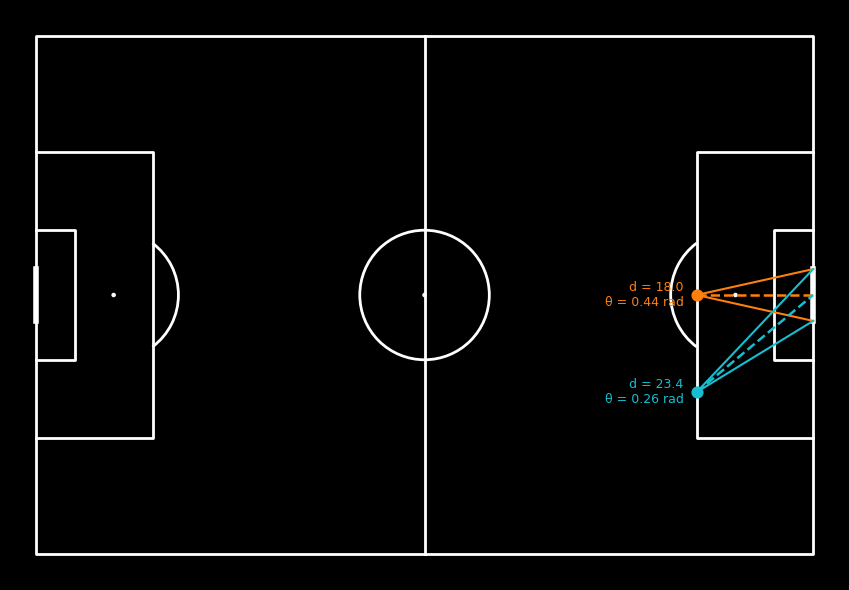

In [137]:
shot_1 = np.array([102, 40])   
shot_2 = np.array([102, 55])  

shots = [shot_1, shot_2]
colors = ["tab:orange", "tab:cyan"]

pitch = Pitch(
    pitch_type="statsbomb",
    pitch_color="black",     # ← black pitch background
    line_color="white",
)

fig, ax = pitch.draw(figsize=(10, 6))

# Figure and axes background
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

goal_center = np.array([GOAL_X, GOAL_CENTER_Y])
top_post = np.array([GOAL_X, GOAL_TOP_POST_Y])
bottom_post = np.array([GOAL_X, GOAL_BOTTOM_POST_Y])

for shot, color in zip(shots, colors):
    # Shot location
    ax.scatter(*shot, color=color, s=60, zorder=6)

    # Distance line
    ax.plot(
        [shot[0], goal_center[0]],
        [shot[1], goal_center[1]],
        color=color,
        linestyle="--",
        linewidth=1.8,
        zorder=3,
    )

    # Angle lines
    ax.plot(
        [shot[0], top_post[0]],
        [shot[1], top_post[1]],
        color=color,
        linewidth=1.5,
        zorder=3,
    )
    ax.plot(
        [shot[0], bottom_post[0]],
        [shot[1], bottom_post[1]],
        color=color,
        linewidth=1.5,
        zorder=3,
    )

    d = shot_distance(*shot)
    a = shot_angle(*shot)

    ax.text(
        shot[0] - 2,
        shot[1],
        f"d = {d:.1f}\nθ = {a:.2f} rad",
        fontsize=9,
        color=color,
        ha="right",
        va="center",
        zorder=7,
    )

plt.show()

Beyond the **shot location** itself and its derived geometric attributes (such as shot distance and opening angle), **player positioning** at the moment of the shot constitutes another critical source of information for xG modeling. 

In StatsBomb event data, this information is provided through a freeze-frame snapshot associated with each shot event. Each freezeframe object is structured as follows:

| Column    | Type        | Child     | Child Type     |
|-----------|-------------|-----------|----------------|
| location  | array [x,y] |           |                |
| player    | object      | id / name | integer / text |
| position  | object      | id / name | integer / text |
| teammate  | boolean     |           |                |

For the purposes of this model, we focus on a compact and interpretable representation of this context: 
- the location of the goalkeeper 
- the location(s) of k nearest opposing defender(s) relative to the shot location.

In [50]:
def closest_defenders(freeze_frame, shot_xy, k=2):
    """
    Identify the goalkeeper location and the k closest non-goalkeeper defenders
    to a given shot location.
    """
    goalkeeper_location = [np.nan, np.nan]
    defender_locations = [[np.nan, np.nan] for _ in range(k)]

    opponent_distances = []

    for player in freeze_frame:
        if player.get("teammate"):
            continue

        location = player["location"]

        if player["position"]["name"] == "Goalkeeper":
            goalkeeper_location = location
        else:
            distance = np.hypot(*(np.array(location) - shot_xy))
            opponent_distances.append((distance, location))

    opponent_distances.sort(key=lambda t: t[0])

    for i in range(min(k, len(opponent_distances))):
        defender_locations[i] = opponent_distances[i][1]

    return goalkeeper_location, defender_locations

When a shot is assisted, we also want to extract key contextual information about the assist: 
- the start location from which the pass is played
- the end location of the pass
- the nature of the delivery (specifically whether it is a lofted pass or a through ball).

For unassisted shots, all assist-related features are set to missing values, ensuring a consistent and well-defined feature schema across all shots.

In [54]:
def extract_assist_features(shot_info, event_by_id):
    """
    Extract assist-related features for a shot, if an assist exists.
    """
    key_pass_id = shot_info.get("key_pass_id")
    shot_assisted = bool(key_pass_id)

    if not shot_assisted:
        return {
            "shot_assisted": False,
            "assist_x": np.nan,
            "assist_y": np.nan,
            "assist_end_x": np.nan,
            "assist_end_y": np.nan,
            "lofted_pass": np.nan,
            "through_ball": np.nan,
        }

    assist_event = event_by_id.get(key_pass_id)
    assist_info = assist_event.get("pass", {}) if assist_event else {}

    assist_x, assist_y = assist_event.get("location", [np.nan, np.nan])
    assist_end = assist_info.get("end_location", [np.nan, np.nan])
    assist_end_x, assist_end_y = assist_end[0], assist_end[1]

    raw_height = assist_info.get("height", {}).get("name")
    if raw_height == "High Pass":
        lofted_pass = 1.0
    elif raw_height in ("Ground Pass", "Low Pass"):
        lofted_pass = 0.0
    else:
        lofted_pass = np.nan

    raw_technique = assist_info.get("technique", {}).get("name")
    through_ball = 1.0 if raw_technique == "Through Ball" else 0.0

    return {
        "shot_assisted": True,
        "assist_x": assist_x,
        "assist_y": assist_y,
        "assist_end_x": assist_end_x,
        "assist_end_y": assist_end_y,
        "lofted_pass": lofted_pass,
        "through_ball": through_ball,
    }


The features described above are those that must be explicitly constructed. StatsBomb event data also provides a set of **categorical shot descriptors** that are directly annotated as part of each shot event.

| shot_body_part | shot_technique     | play_pattern     | shot_type   |
|----------------|--------------------|------------------|-------------|
| Head           | Backheel           | From Corner      | Corner      |
| Left Foot      | Diving Header      | From Counter     | Free Kick   |
| Other          | Half Volley        | From Free Kick   | Kick Off    |
| Right Foot     | Lob                | From Goal Kick   | Open Play   |
|                | Normal             | From Keeper      | Penalty     |
|                | Overhead Kick      | From Kick Off    |             |
|                | Volley             | From Throw In    |             |
|                |                    | Other            |             |
|                |                    | Regular Play     |             |

We incorporate these variables directly into the feature set as well.

In [59]:
def extract_shot_features(events, event_by_id, shot_distance, shot_angle, closest_defenders):
    rows = []

    for event in events:
        if event.get("type", {}).get("name") != "Shot":
            continue

        shot_x, shot_y = event.get("location", [np.nan, np.nan])
        shot_info = event.get("shot", {})
        freeze_frame = shot_info.get("freeze_frame", [])

        goalkeeper_loc, defender_locs = closest_defenders(
            freeze_frame, np.array([shot_x, shot_y])
        )

        defender_locs = (defender_locs or []) + [[np.nan, np.nan]] * (2 - len(defender_locs or []))
        (def1_x, def1_y), (def2_x, def2_y) = defender_locs[:2]

        gk_x, gk_y = goalkeeper_loc if goalkeeper_loc else [np.nan, np.nan]

        assist_features = extract_assist_features(shot_info, event_by_id)

        rows.append({
            # Shot location & geometry
            "shot_x": shot_x,
            "shot_y": shot_y,
            "shot_distance": shot_distance(shot_x, shot_y),
            "shot_angle": shot_angle(shot_x, shot_y),

            # Pre-existing categorical shot descriptors
            "shot_body_part": shot_info.get("body_part", {}).get("name"),
            "shot_technique": shot_info.get("technique", {}).get("name"),
            "shot_type": shot_info.get("type", {}).get("name"),
            "play_pattern": event.get("play_pattern", {}).get("name"),

            # Defensive context
            "gk_x": gk_x,
            "gk_y": gk_y,
            "def1_x": def1_x,
            "def1_y": def1_y,
            "def2_x": def2_x,
            "def2_y": def2_y,

            # Assist context
            **assist_features,

            # Goal Label
            "goal": shot_info.get("outcome", {}).get("name") == "Goal",
        })

    return rows

This last helper function below constructs the final design matrix and target vector for xG modeling. 

In [ ]:
def prepare_xg_features(df: pd.DataFrame):
    numeric_features = [
        "shot_x", "shot_y",
        "shot_distance", 
        "shot_angle",

        "assist_x", "assist_y",
        "assist_end_x", "assist_end_y",

        "gk_x", "gk_y",
        "def1_x", "def1_y",
        "def2_x", "def2_y",
        
        "shot_assisted", 
        "lofted_pass", 
        "through_ball",
    ]

    categorical_features = [
        "shot_body_part", 
        "shot_technique", 
        "play_pattern", 
        "shot_type"
    ]

    X_num = df.reindex(columns=numeric_features)

    X_num = X_num.astype({
        "shot_assisted": "UInt8",  # 'shot_assisted' is always 0 or 1, never missing
        "through_ball": "float",   # can legitimately take 'NaN' (when the shot is not assisted)
        "lofted_pass":  "float",   # can legitimately take 'NaN' (when the shot is not assisted)
    }, errors="ignore")

    X_cat = pd.get_dummies(
        df.reindex(columns=categorical_features).fillna("Unknown"),
        prefix=categorical_features,
        dtype="uint8"
    )

    # Merge into a single feature matrix where each row represents one shot
    X = pd.concat([X_num, X_cat], axis=1)

    y = df["goal"].astype("uint8") 

    return X, y

At this stage, we can finally put all the pieces together and prepare the data for modeling.

We start by extracting shot-level features from the raw event data. For each shot, we gather everything we care about: where the shot was taken, the surrounding defensive context, whether the shot was assisted and how the assist was played, and the categorical information already provided by StatsBomb. These per-shot records are then collected into a DataFrame so that each row corresponds to a single shot.

Once we have this structured table, we transform it into a feature matrix and target vector that a machine-learning model can work with. Numeric features and encoded categorical variables are combined into a single matrix `X`, while the target `y` indicates whether each shot resulted in a goal.

To train and evaluate the model properly, we split the data into `training`, `validation`, and `test` sets. The splits are stratified by the goal outcome, which ensures that each subset contains a similar proportion of goals and non-goals. This helps us evaluate model performance without introducing bias from imbalanced splits.

In [71]:
# --------------------------------------------------
# Shot-level feature extraction
# --------------------------------------------------
shot_feature_rows = extract_shot_features(
    events=events,
    event_by_id=event_by_id,
    shot_distance=shot_distance,
    shot_angle=shot_angle,
    closest_defenders=closest_defenders,
)

df = pd.DataFrame(shot_feature_rows)

X, y = prepare_xg_features(df)

# --------------------------------------------------
# Train / validation / test split
# --------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.10,
    stratify=y,
    random_state=42,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.10,
    random_state=42,
)

# --------------------------------------------------
# Category inspection 
# --------------------------------------------------
unique_categories = {
    col: sorted(df[col].dropna().unique().tolist())
    for col in [
        "shot_body_part",
        "shot_technique",
        "play_pattern",
        "shot_type",
    ]
}

### Train the xG model

In traditional xG modeling approaches - such as logistic regression - we usually assume that **each shot feature corresponds to a parameter** in the model. Training then consists of adjusting these parameters so that the predicted probabilities match the observed outcomes.

Formally, a classic model looks like:

$$
\hat{p} = \sigma\left(w_0 + w_1 x_1 + w_2 x_2 + \dots + w_d x_d\right),
$$

where:
- each feature $x_j$ (e.g. shot distance, shot angle) has a **single global weight** $w_j$,
- the effect of a feature is linear and identical across all shots,
- learning means directly updating the weights $w_j$ via gradient descent.

This is the perspective commonly illustrated in introductory gradient-descent explanations (such as the 3Blue1Brown videos): features are inputs, weights are parameters, and training nudges those weights to reduce the loss.

XGBoost departs from this assumption. Instead of assigning **one fixed weight per feature**, it represents the prediction function as a **sum of decision trees**:

$$
f(x) = \sum_{m=1}^{M} T_m(x),
\qquad
\hat{p} = \sigma\big(f(x)\big).
$$

Here:
- each $T_m(x)$ is a decision tree,
- trees are **piecewise-constant functions**,
- features are used to *split* the data (e.g. “is shot angle > 0.35?”), not to scale linearly.

As a result, there is **no single global coefficient** for a feature like shot angle or distance. A feature can matter:
- a lot in one region of the feature space,
- very little in another,
- only when combined with other conditions (e.g. defender distance, shot type).

XGBoost still minimizes the same binary cross-entropy (log loss):

$$
\mathcal{L} = -\left[y \log(\hat{p}) + (1-y)\log(1-\hat{p})\right],
$$

but it uses gradients in a different way.

Rather than updating parameters directly, the algorithm:
1. Computes the gradient of the loss for each shot.
2. Fits a new decision tree to approximate the **negative gradient**.
3. Adds this tree to the existing ensemble.

In other words, gradients tell the model **what structure to add next**, not how to tweak a fixed set of weights.

**Logistic Regression Model:**  
  Each feature pushes the probability up or down by a fixed amount everywhere.

In [79]:
# Impute missing values
imputer = SimpleImputer(strategy="constant", fill_value=0.0)

X_train_lr = imputer.fit_transform(X_train)
X_val_lr   = imputer.transform(X_val)
X_test_lr  = imputer.transform(X_test)

# Train logistic regression
log_reg_model = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    n_jobs=-1,
)

log_reg_model.fit(X_train_lr, y_train)

probs_lr = log_reg_model.predict_proba(X_test_lr)[:, 1]

print("LogReg ROC-AUC :", roc_auc_score(y_test, probs_lr))
print("LogReg Brier  :", brier_score_loss(y_test, probs_lr))
print("LogReg LogLoss:", log_loss(y_test, probs_lr))

LogReg ROC-AUC : 0.8029884606386468
LogReg Brier  : 0.07891466057102318
LogReg LogLoss: 0.27651748592656694


**XGBoost:**  
  Features define conditional rules, and their influence depends on *where* in the feature space a shot lies.

In [80]:
xgboost_model = XGBClassifier(
    objective="binary:logistic", 
    eval_metric="logloss",
    n_estimators=110, 
    learning_rate=0.05,
    max_depth=6, 
    subsample=0.8, 
    colsample_bytree=0.4,
    random_state=42,
)

xgboost_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

probs = xgboost_model.predict_proba(X_test)[:,1]

print("xGBoost ROC-AUC :", roc_auc_score(y_test, probs))
print("xGBoost Brier   :", brier_score_loss(y_test, probs))
print("xGBoost LogLoss :", log_loss(y_test, probs))

xGBoost ROC-AUC : 0.8109021559080152
xGBoost Brier   : 0.07838534601979417
xGBoost LogLoss : 0.27329213075799136


Both approaches optimize the same loss function, but they assume **very different shapes** for the underlying xG function.

Because logistic regression learns a single global weight for each feature, this structure makes it possible to ask clear, interpretable questions such as:

> *“If I vary one feature while keeping all other features fixed, how does the predicted goal probability change?”*

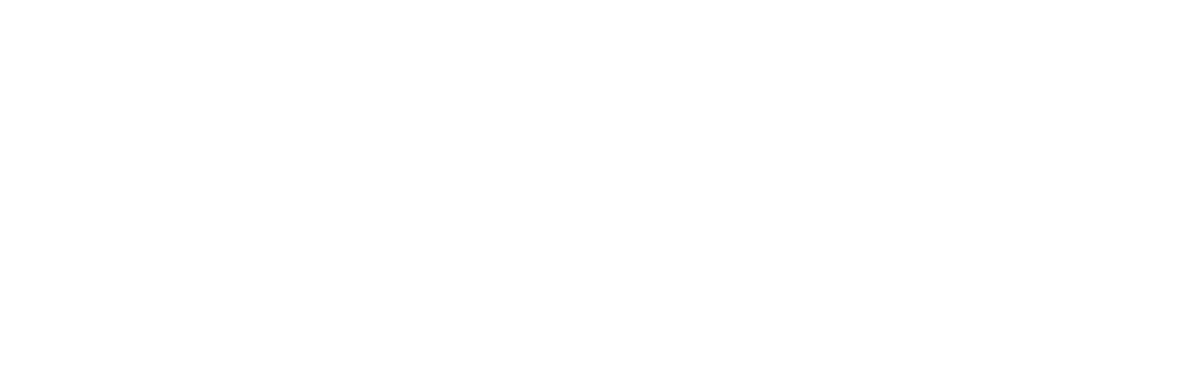

In [86]:
# Reference point (all other features fixed)
X_ref = X_train.fillna(0.0)
feature_means = X_ref.mean()

# Features to sweep
sweep_specs = [
    ("shot_distance", "Shot distance"),
    ("shot_angle", "Shot angle"),
]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
fig.patch.set_alpha(0)

for ax, (feat, label) in zip(axes, sweep_specs):
    grid = np.linspace(X_ref[feat].min(), X_ref[feat].max(), 100)

    X_sweep = pd.DataFrame(
        [feature_means.values] * len(grid),
        columns=X_ref.columns
    )
    X_sweep[feat] = grid

    probs = log_reg_model.predict_proba(X_sweep)[:, 1]

    ax.set_facecolor("none")
    ax.plot(grid, probs, color="white")
    ax.set_xlabel(label, color="white")
    ax.set_title(f"Marginal effect of {label.lower()}", color="white")

    ax.tick_params(colors="white")
    for spine in ax.spines.values():
        spine.set_color("white")

axes[0].set_ylabel("Predicted goal probability", color="white")

plt.tight_layout()
plt.show()


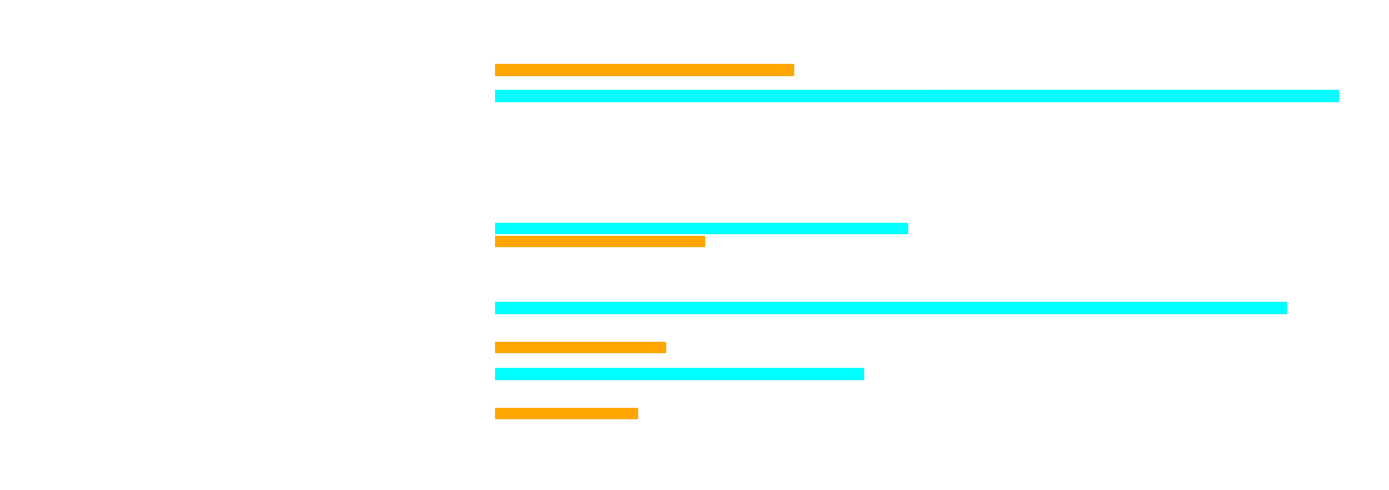

In [93]:
# Reference feature vector (all other features fixed)
X_ref = X_train.fillna(0.0)
feature_means = X_ref.mean()

# LEFT PANEL: Assist vs no assist
X_assist = pd.DataFrame(
    [feature_means.values, feature_means.values],
    columns=X_ref.columns
)
X_assist.loc[0, "shot_assisted"] = 0
X_assist.loc[1, "shot_assisted"] = 1

probs_assist = log_reg_model.predict_proba(X_assist)[:, 1]

# RIGHT PANEL: Categorical features with highlights
cat_features = [
    "shot_body_part",
    "shot_technique",
    "play_pattern",
    "shot_type",
]

y_positions = []
y_labels = []
values = []
colors = []

y_cursor = 0

for feat in cat_features:
    cols = [c for c in X_ref.columns if c.startswith(f"{feat}_")]

    group_probs = []
    group_labels = []

    # Compute probabilities for this category group
    for c in cols:
        X_tmp = feature_means.copy()
        X_tmp[cols] = 0
        X_tmp[c] = 1

        prob = log_reg_model.predict_proba(
            pd.DataFrame([X_tmp])
        )[0, 1]

        group_probs.append(prob)
        group_labels.append(c.replace(f"{feat}_", ""))

    # Identify extrema within the group
    max_idx = int(np.argmax(group_probs))
    min_idx = int(np.argmin(group_probs))

    # Append to global plotting lists
    for i, (label, prob) in enumerate(zip(group_labels, group_probs)):
        y_positions.append(y_cursor)
        y_labels.append(label)
        values.append(prob)

        if i == max_idx:
            colors.append("cyan")
        elif i == min_idx:
            colors.append("orange")
        else:
            colors.append("white")

        y_cursor += 1

    y_cursor += 1  # gap between category groups

# Plot 

fig, axes = plt.subplots(
    1, 2,
    figsize=(14, 5),
    gridspec_kw={"width_ratios": [1, 3]}
)

# Transparent background
fig.patch.set_alpha(0)
for ax in axes:
    ax.set_facecolor("none")

# ---- Left panel: assist effect ----
axes[0].bar(
    ["Not assisted", "Assisted"],
    probs_assist,
    color="white",
    edgecolor="white",
)
axes[0].set_title("Marginal effect of assist", color="white")
axes[0].set_ylabel("Predicted goal probability", color="white")

# ---- Right panel: categorical effects ----
axes[1].barh(
    y_positions,
    values,
    color=colors,
    edgecolor=colors,
)
axes[1].set_yticks(y_positions)
axes[1].set_yticklabels(y_labels, color="white")
axes[1].set_xlabel("Predicted goal probability", color="white")
axes[1].set_title("Marginal effects of shot categories", color="white")

# ---- Styling ----
for ax in axes:
    ax.tick_params(colors="white")
    for spine in ax.spines.values():
        spine.set_color("white")

plt.tight_layout()
plt.show()


How should we interpret the data?

Remember, this analysis provides insight into model behavior and feature effects, not direct recommendations for how players or teams should alter their playstyle.

When the model assigns a high marginal probability to free kicks, it does not mean:
- free kicks are inherently “easy”
- players should seek more free kicks

What it does mean is: **Within the current feature set, “free kick” still carries unexplained structure that the model is using as a proxy.**

In other words, the category is acting as a container for latent factors that have not yet been explicitly modeled.

Our current feature set already captures several key determinants of shot quality, including shot distance, shot angle, defensive proximity, and goalkeeper position. Despite this, the `free kick` category remains strongly predictive in the model.

This indicates that `free kicks` differ from open-play shots in systematic ways that are **not yet explicitly represented by these features**. Examples of such latent structure include *wall positioning* and *gaps*, *ball placement* and *curvature*, *specialized shooting techniques*, *goalkeeper anticipation*, and the *relatively reduced defensive pressure* at the moment of the shot.

As a result, the categorical `free kick` label is effectively acting as a proxy, absorbing the combined influence of these unmodeled factors.

A useful way to interpret this behavior is through the following mental model:

>High category effect = missing feature opportunity

Therefore, when the model assigns a higher predicted probability to free kicks, the correct conclusion is not that free kicks are inherently “better” shots, but rather that there exist additional, structured dimensions of free kicks that have not yet been explicitly modeled. Identifying and encoding these dimensions would shift explanatory power away from the categorical label and toward more interpretable, geometry- or context-based features.

### Save and test the xG model

In [ ]:
joblib.dump((xgboost_model, X.columns.tolist()), "xgb_xG_model.pkl")
joblib.dump((xgboost_model, X.columns.tolist()), "lr_xG_model.pkl")
print("Model saved")

Model saved


In this step, we prepare a single shot sample for model inference, ensuring that it is processed in exactly the same way as the training data.

In [98]:
_BASE = [
    "shot_x", "shot_y",
    "shot_distance", "shot_angle",
    "gk_x", "gk_y",
    "def1_x", "def1_y",
    "def2_x", "def2_y",
    "assist_x", "assist_y",
    "assist_end_x", "assist_end_y",
    "lofted_pass", "through_ball",
    "shot_assisted",  
]
_CAT = ["shot_body_part", "shot_technique", "play_pattern", "shot_type"]

In [104]:
def _recompute_geom(sample):
    """
    Recompute geometric shot features if shot location is available.
    """
    if "shot_x" not in sample or "shot_y" not in sample:
        return sample

    sx, sy = float(sample["shot_x"]), float(sample["shot_y"])
    out = dict(sample)
    out["shot_distance"] = shot_distance(sx, sy)
    out["shot_angle"] = shot_angle(sx, sy)
    return out


def _prepare_single_row(sample, cols):
    """
    Prepare a single sample for inference by mirroring training-time
    feature construction and encoding.
    """
    sample = _recompute_geom(sample)
    df = pd.DataFrame([sample])

    # --------------------------------------------------
    # Assisted-shot handling (mirror training semantics)
    # --------------------------------------------------
    shot_assisted = int(df.loc[0, "shot_assisted"]) if "shot_assisted" in df.columns and pd.notna(df.loc[0, "shot_assisted"]) else 0
    df["shot_assisted"] = shot_assisted
    df["shot_assisted"] = df["shot_assisted"].astype("UInt8")

    if shot_assisted == 0:
        for f in [
            "assist_x", "assist_y",
            "assist_end_x", "assist_end_y",
            "lofted_pass", "through_ball",
        ]:
            df[f] = np.nan

    # --------------------------------------------------
    # Ensure numeric base columns exist
    # --------------------------------------------------
    for c in _BASE:
        if c not in df.columns:
            df[c] = np.nan

    for f in ["through_ball", "lofted_pass"]:
        if f in df.columns:
            df[f] = df[f].astype("float")

    # --------------------------------------------------
    # Categorical handling (Unknown + one-hot)
    # --------------------------------------------------
    for c in _CAT:
        if c not in df.columns or pd.isna(df.loc[0, c]):
            df[c] = "Unknown"

    X_num = df[_BASE]
    X_cat = pd.get_dummies(df[_CAT], prefix=_CAT, dtype="uint8")

    # --------------------------------------------------
    # Final alignment with training feature space
    # --------------------------------------------------
    X = pd.concat([X_num, X_cat], axis=1)
    X = X.loc[:, ~X.columns.duplicated()]
    X = X.reindex(columns=cols, fill_value=0)

    return X

In [100]:
def predict_xg(sample: dict, model_path: str):
    model, cols = joblib.load(model_path)
    X = _prepare_single_row(sample, cols)
    return float(model.predict_proba(X)[0, 1])

In [ ]:
example = {
    "shot_x": 112.59, "shot_y":  45.17,

    "gk_x": 117.07, "gk_y":42.12,       
    "def1_x": 113.46, "def1_y": 44.18,        
    "def2_x": 111.51, "def2_y": 49.2,      
    
    "assist_x": 108.23, "assist_y":56.42,          
    "assist_end_x": 112.59, "assist_end_y":  45.17,       
    "lofted_pass": 1.0, "through_ball": 0.0,
    "shot_assisted": 1,
    
    "shot_body_part": "Head",
    "shot_technique": "Normal",
    "shot_type": "Regular Play",
    "play_pattern": "Open Play",
}

print("xG:", round(predict_xg(example, "lr_xG_model.pkl"), 4))

xG: 0.1827


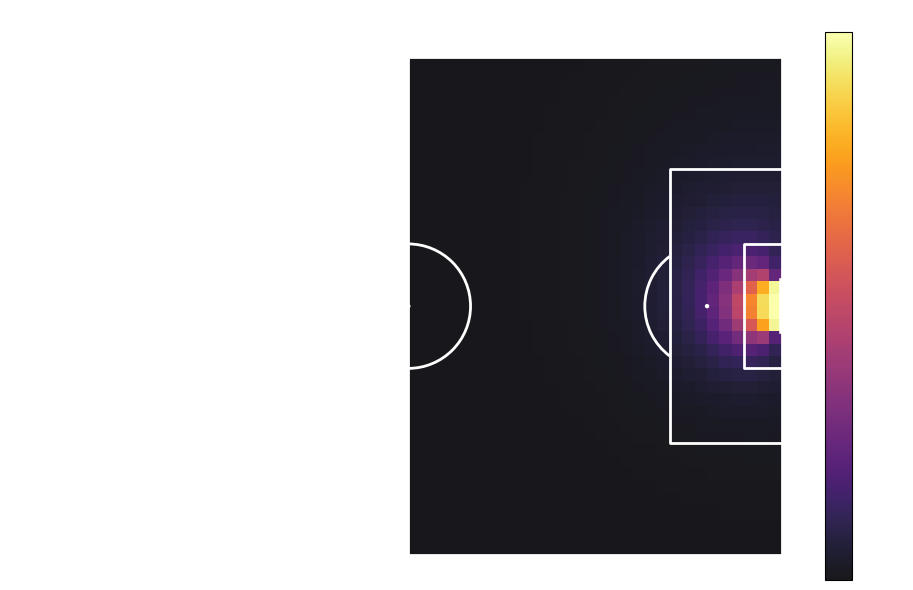

In [136]:
# Build spatial grid (StatsBomb coordinates)
x = np.linspace(60, 120, 60)   # attacking half
y = np.linspace(0, 80, 40)
xx, yy = np.meshgrid(x, y)

# Reference feature vector (non-spatial fixed)
X_ref = X_train.fillna(0.0)
feature_means = X_ref.mean()

rows = []
for xi, yi in zip(xx.ravel(), yy.ravel()):
    r = feature_means.copy()
    r["shot_x"] = xi
    r["shot_y"] = yi
    r["shot_distance"] = shot_distance(xi, yi)
    r["shot_angle"] = shot_angle(xi, yi)
    rows.append(r)

X_grid = pd.DataFrame(rows)[X_train.columns]

# Predict xG
xg = log_reg_model.predict_proba(X_grid)[:, 1]

# Bin into pitch grid 
pitch = Pitch(
    pitch_type="statsbomb",
    line_color="white",
    line_zorder=3,
)

bin_stat = pitch.bin_statistic(
    X_grid["shot_x"].values,
    X_grid["shot_y"].values,
    xg,
    statistic="mean",
    bins=(60, 40),
)

# Plot heatmap
fig, ax = pitch.draw(figsize=(10, 6))
fig.patch.set_alpha(0)
ax.set_facecolor("none")

hm = pitch.heatmap(
    bin_stat,
    ax=ax,
    cmap="inferno",
    alpha=0.9,
    zorder=1,
)

cbar = plt.colorbar(hm, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label("Expected Goal", color="white")
cbar.ax.yaxis.set_tick_params(color="white")
plt.setp(cbar.ax.get_yticklabels(), color="white")

plt.title("Log-reg-based xG heatmap", color="white")
plt.show()

### What's Next?

The current xG model focuses on shot-level context and geometry at the moment of the attempt, using freeze-frame information to capture player positioning. While this already provides a strong baseline, there are several clear directions for extending and refining the model.

One natural extension is to move beyond static player locations and incorporate **defensive pressure**. StatsBomb events include pressure actions and related contextual signals that indicate whether the shooter is being actively closed down at the time of the shot. Explicitly modeling pressure — for example, whether a defender is applying pressure, the number of nearby pressure events, or the distance to the nearest pressing defender — would help distinguish between visually similar shots taken under very different levels of constraint.

Another avenue is **feature decomposition guided by model diagnostics**. Earlier analysis showed that certain categorical variables, such as set-piece situations, retain strong predictive power even after accounting for shot geometry. This suggests that these categories are absorbing structured information not yet explicitly represented. For example, set pieces could be decomposed into features describing wall structure, goalkeeper positioning relative to the wall, or the angle of approach to the ball. In this sense, high category effects act as indicators of missing or overly coarse features.

There is also room for improvement at the **modeling level**. The current setup compares a linear logistic regression model with a nonlinear tree-based model. Future iterations could explore regularized generalized additive models (GAMs) for smoother nonlinear effects with interpretability, or hierarchical models that separate shooter skill and goalkeeper ability from shot difficulty. Neural network–based approaches could also be considered, particularly when richer contextual or tracking data becomes available.

Finally, improvements can be made at the **training and evaluation level**. These include more careful handling of class imbalance, cross-validation across competitions or seasons to test generalization, and calibration-focused training objectives. Rather than optimizing a single metric, future versions of the model could explicitly balance discrimination, calibration, and stability across different game contexts.

Overall, these directions reflect a shift from a static, shot-only view toward a richer representation of **context, interaction, and uncertainty**, while maintaining the core principle that xG should remain interpretable and grounded in football-specific structure.

